In [286]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pygad
from pygad import torchga

In [287]:
input_layer = torch.nn.Linear(28*28, 50)
relu = torch.nn.ReLU()
dense_layer = torch.nn.Linear(50, 10)
softmax = torch.nn.Softmax(1)

model = torch.nn.Sequential(input_layer,
                            relu,
                            dense_layer,
                            softmax)

In [288]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [289]:
import numpy as np

In [290]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [325]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size= 50000, 
                                          shuffle=True,
                                          num_workers = 1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True)
}
for batch_idx, (data, target) in enumerate(loaders['train']):
    data_inputs = data
    data_outputs = target

In [292]:
losses = []

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function
    data_inputs = data_inputs.view(-1, 28*28) 
    predictions = pygad.torchga.predict(model=model,
                                        solution=solution,
                                        data=data_inputs)
    solution_fitness = 1.0 / (loss_function(predictions, data_outputs).detach().numpy() + 0.00000001)
    losses.append(loss_function(predictions, data_outputs).item())
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [329]:
model.load_state_dict(torch.load("gaModel.pth"))
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=100)

loss_function = torch.nn.CrossEntropyLoss()

In [330]:
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=100,
                       sol_per_pop=100,
                       crossover_type="single_point",
                       parent_selection_type="rank",
                       mutation_percent_genes = 1,
                       num_parents_mating=20,
                       keep_parents = 1,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)


Generation = 1
Fitness    = 0.6194266220604551
Generation = 2
Fitness    = 0.6198166123053213
Generation = 3
Fitness    = 0.6199843661142895
Generation = 4
Fitness    = 0.620343358086244
Generation = 5
Fitness    = 0.6204068553359037
Generation = 6
Fitness    = 0.6205108922872323
Generation = 7
Fitness    = 0.6205856258388085
Generation = 8
Fitness    = 0.6209626435213136
Generation = 9
Fitness    = 0.6209626435213136
Generation = 10
Fitness    = 0.6210132107436114
Generation = 11
Fitness    = 0.6215024368097629
Generation = 12
Fitness    = 0.6215024368097629
Generation = 13
Fitness    = 0.6215024368097629
Generation = 14
Fitness    = 0.6215024368097629
Generation = 15
Fitness    = 0.6216172056519027
Generation = 16
Fitness    = 0.621728514795824
Generation = 17
Fitness    = 0.6218122071865261
Generation = 18
Fitness    = 0.6220773510484758
Generation = 19
Fitness    = 0.6220773510484758
Generation = 20
Fitness    = 0.6220773510484758
Generation = 21
Fitness    = 0.6220773510484758
Gen

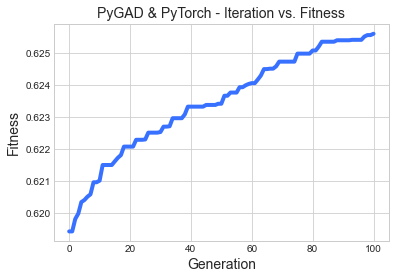

Fitness value of the best solution = 0.6256047669239606
Index of the best solution : 91
Crossentropy :  1.5984533
Accuracy :  0.8626


In [331]:

# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                        weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)

print("Crossentropy : ", loss_function(predictions, data_outputs).detach().numpy())

# Calculate the classification accuracy for the trained model.
accuracy = torch.sum(torch.max(predictions, axis=1).indices == data_outputs) / len(data_outputs)
print("Accuracy : ", accuracy.detach().numpy())

In [332]:
total = 0
correct = 0
for k, (data, target) in enumerate(loaders['test']):
    data = data.view(-1, 28*28)
    
    outputs = model(data)
    predicted = torch.argmax(outputs.data, dim = 1)
    
    correct += (predicted == target).sum().item()
    total += target.size(0)
print(correct/total)

0.8625


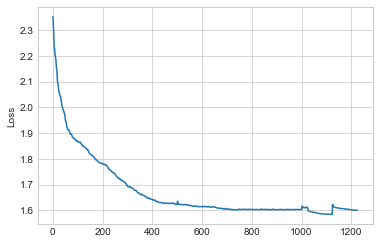

In [333]:
import matplotlib.pyplot as plt

new_losses = []
running_loss = 0
for idx, loss in enumerate(losses):
    running_loss += loss
    if idx % 200 == 199:
        new_losses.append(running_loss/200)
        running_loss = 0

plt.style.use('seaborn-whitegrid')
figure = plt.figure()
ax1 = figure.add_subplot()
ax1.set_ylabel('Loss')
ax1.plot(new_losses)

In [334]:
PATH = 'gaModel.pth'

In [335]:
torch.save(model.state_dict(), PATH)

In [336]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [337]:
def accuracy_by_num(model, test_data):
    fails = np.zeros(10) # Network's mistakes by number
    nums = np.zeros(10) # Amount of each number

    for i, (data, target) in enumerate(test_data):
        data = data.view(-1, 28*28)
        outputs = model(data)
        predicted = torch.argmax(outputs.data, dim = 1)
    
        for i, element in enumerate(predicted):
            nums[target[i]] = nums[target[i]] + 1
            if element != target[i]:
                fails[target[i]] = fails[target[i]] + 1

    accuracy_by_num = 1 - np.divide(fails, nums)
    return np.around(accuracy_by_num, 4)

In [338]:
accuracy_by_num(model, loaders['test'])

array([0.9408, 0.9383, 0.8653, 0.8347, 0.8849, 0.7836, 0.8852, 0.8599,
       0.7947, 0.8206])

In [43]:
x = torch.randn(100, 28*28)
onnx_path = "gaModel.onnx"
torch.onnx.export(model, x, onnx_path)